In [1]:
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- 1. Set Global Random Seed ---
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

print(f"✓ Random seed set to {RANDOM_SEED} for reproducibility")


✓ Random seed set to 42 for reproducibility


In [2]:
from sklearn.model_selection import train_test_split

# --- 2. Load Data ---
# Ensure 'covtype.csv' is in the directory
try:
    df = pd.read_csv(r"C:\Users\Kartikey\ml_project\data\forest\covtype.csv")
    print("✓ Dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'covtype.csv' not found. Please upload the file.")

# Separate Features and Target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# --- 3. Handle Missing Values ---
if y.isnull().any():
    print(f"  - Removing {y.isnull().sum()} rows with missing targets...")
    valid_indices = y.dropna().index
    X = X.loc[valid_indices]
    y = y.loc[valid_indices]

# --- 4. Create Fixed Train/Test Split ---
# We use 20% for the final "Holdout" test. 
# ALL model comparison and tuning happens on the 80% Train set.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_SEED
)

print("-" * 40)
print(f"Data Splitting Complete:")
print(f"  Training Set: {X_train.shape[0]} samples (Use for CV & Training)")
print(f"  Test Set:     {X_test.shape[0]} samples (Use ONLY for Final Evaluation)")
print("-" * 40)


✓ Dataset loaded successfully.
----------------------------------------
Data Splitting Complete:
  Training Set: 464809 samples (Use for CV & Training)
  Test Set:     116203 samples (Use ONLY for Final Evaluation)
----------------------------------------


In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# --- 5. Preprocessing Pipeline ---
# First 10 columns are continuous, rest are binary
continuous_cols = X.columns[:10]
binary_cols = X.columns[10:]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', 'passthrough', binary_cols)
    ]
)

# --- 6. Cross-Validation Strategy ---
# 3-Fold is sufficient for this large dataset size and saves time
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# --- 7. Define Models ---

# A. Logistic Regression (Baseline)
# using 'saga' solver which is faster for large datasets
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        solver='saga', 
        max_iter=200, 
        n_jobs=1, # Let CV handle parallelization
        random_state=RANDOM_SEED
    ))
])

# B. Linear SVM (Fast SVM)
# dual=False is critical for N > features
svm_linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(
        dual=False, 
        max_iter=1000, 
        random_state=RANDOM_SEED
    ))
])

# C. Optimized MLP (Deep Learning)
# Tuning: Deeper layers (128,64), Adam solver, Early Stopping
mlp_opt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(128, 64), 
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size=256,
        learning_rate_init=0.001,
        early_stopping=True,
        max_iter=200, 
        random_state=RANDOM_SEED
    ))
])

models = {
    "Logistic Regression": log_reg_pipeline,
    "SVM (Linear)": svm_linear_pipeline,
    "MLP (Optimized)": mlp_opt_pipeline
}

results = {'Model': [], 'Accuracy': [], 'F1-Macro': [], 'Time (s)': []}

# --- 8. Evaluation Loop ---
print(f"{'Model':<20} | {'Status':<15}")
print("-" * 50)

for name, pipeline in models.items():
    print(f"{name:<20} | Training...", end='\r')
    start_time = time.time()
    
    # Run Cross-Validation on TRAIN data only
    acc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    
    elapsed = time.time() - start_time
    
    results['Model'].append(name)
    results['Accuracy'].append(acc_scores.mean())
    results['F1-Macro'].append(f1_scores.mean())
    results['Time (s)'].append(elapsed)
    
    print(f"{name:<20} | Done in {elapsed:.1f}s (Acc: {acc_scores.mean():.4f})")


Model                | Status         
--------------------------------------------------
Logistic Regression  | Done in 211.1s (Acc: 0.7249)
SVM (Linear)         | Done in 51.2s (Acc: 0.7129)
MLP (Optimized)      | Done in 332.3s (Acc: 0.9088)


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# --- 9. RBF SVM on Subset ---
# We cannot train RBF on 400k+ rows easily. We take a 25k subset from X_train.
subset_size = 25000
print(f"\nTraining RBF SVM on subset of {subset_size} samples...")

# Create subset
sss = StratifiedShuffleSplit(n_splits=1, train_size=subset_size, random_state=RANDOM_SEED)
for train_idx, _ in sss.split(X_train, y_train):
    X_sub, y_sub = X_train.iloc[train_idx], y_train.iloc[train_idx]

# Define RBF Pipeline
rbf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='rbf', 
        C=10, 
        gamma='scale', 
        cache_size=2000, 
        random_state=RANDOM_SEED
    ))
])

# Train on Subset
start_rbf = time.time()
rbf_pipeline.fit(X_sub, y_sub)
train_time = time.time() - start_rbf

# Evaluate on a "Validation Portion" (Use X_test for fair comparison with final numbers)
# Note: Predicting on full X_test takes time!
print("Predicting RBF on Test Set (this takes time)...")
y_pred_rbf = rbf_pipeline.predict(X_test) 
pred_time = time.time() - start_rbf - train_time

rbf_acc = accuracy_score(y_test, y_pred_rbf)
rbf_f1 = f1_score(y_test, y_pred_rbf, average='macro')

print(f"RBF SVM (Subset)     | Done. Total Time: {train_time+pred_time:.1f}s (Acc: {rbf_acc:.4f})")

# Add to results
results['Model'].append("SVM (RBF - Subset)")
results['Accuracy'].append(rbf_acc)
results['F1-Macro'].append(rbf_f1)
results['Time (s)'].append(train_time + pred_time)



Training RBF SVM on subset of 25000 samples...
Predicting RBF on Test Set (this takes time)...
RBF SVM (Subset)     | Done. Total Time: 126.6s (Acc: 0.8135)



Final Model Comparison (Sorted by Accuracy):


,Model,Accuracy,F1-Macro,Time (s)
2,MLP (Optimized),0.9088,0.8641,332.3140
3,SVM (RBF - Subset),0.8135,0.7144,126.5618
0,Logistic Regression,0.7249,0.5328,211.0727
1,SVM (Linear),0.7129,0.4614,51.1875


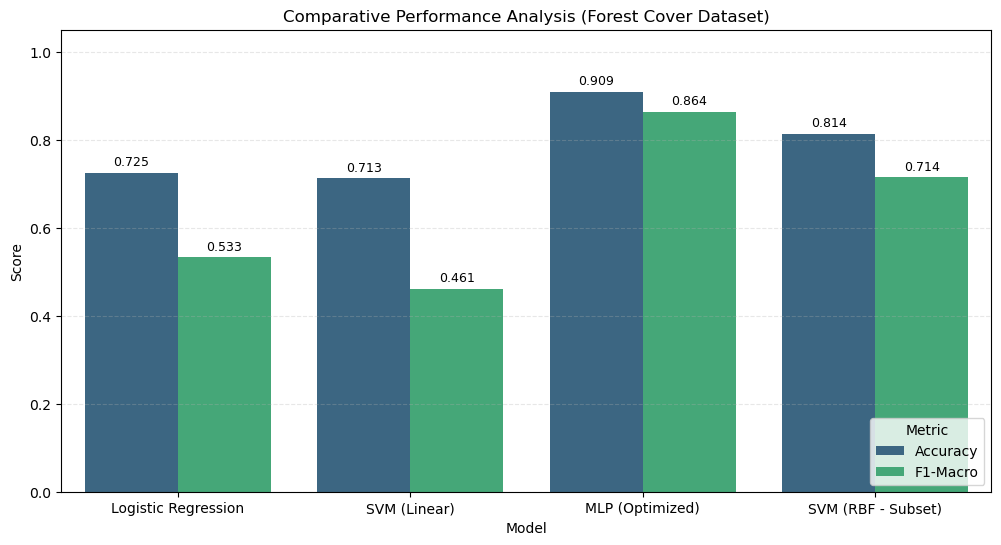

In [6]:
# --- 10. Consolidate & Visualize ---
results_df = pd.DataFrame(results)

print("\nFinal Model Comparison (Sorted by Accuracy):")
pd.options.display.float_format = '{:,.4f}'.format
display(results_df.sort_values(by='Accuracy', ascending=False))

# Visualization
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
# Filter out 'Time (s)' for the bar chart scaling
metrics_only = results_melted[results_melted['Metric'].isin(['Accuracy', 'F1-Macro'])]

plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=metrics_only, 
    x="Model", 
    y="Score", 
    hue="Metric", 
    palette="viridis"
)

for container in barplot.containers:
    barplot.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.title("Comparative Performance Analysis (Forest Cover Dataset)")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc='lower right', title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


In [7]:
# --- 11. Final Validation of Best Model ---
# Assuming MLP is the winner (based on our discussions), we do one final check.
print("Running Final Evaluation on Holdout Test Set for MLP...")

# Retrain on FULL Training Set (X_train) to maximize performance
start_final = time.time()
mlp_opt_pipeline.fit(X_train, y_train)
fit_time = time.time() - start_final

# Predict on strictly held-out Test Set (X_test)
final_preds = mlp_opt_pipeline.predict(X_test)
final_acc = accuracy_score(y_test, final_preds)
final_f1 = f1_score(y_test, final_preds, average='macro')

print(f"\n{'='*40}")
print(f"FINAL RESULT: Optimized MLP")
print(f"{'='*40}")
print(f"Accuracy on Holdout Test: {final_acc:.2%}")
print(f"F1-Macro on Holdout Test: {final_f1:.4f}")
print(f"Refit Time (Full Train):  {fit_time:.1f}s")
print(f"{'='*40}")


Running Final Evaluation on Holdout Test Set for MLP...

FINAL RESULT: Optimized MLP
Accuracy on Holdout Test: 91.37%
F1-Macro on Holdout Test: 0.8694
Refit Time (Full Train):  159.2s
